<a href="https://colab.research.google.com/github/Amaljayaranga/Autoencoders/blob/master/BVAEwithDensenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

training started
epoch: 1 stage: train loss: 503.95896815599997 rec: 0.11315854994952679 KL: 50.384581219236054
epoch: 1 stage: eval loss: 30.54536881637573


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Model is saving :) :)
epoch: 2 stage: train loss: 136.8523829597185 rec: 0.10911791258305312 KL: 13.6743265474389
epoch: 2 stage: eval loss: nan
epoch: 3 stage: train loss: 138.31543684952953 rec: 0.1088751513833801 KL: 13.820656139026086
epoch: 3 stage: eval loss: nan
epoch: 4 stage: train loss: 0.9835417286405961 rec: 0.10856527197112639 KL: 0.08749764570593833
epoch: 4 stage: eval loss: nan
epoch: 5 stage: train loss: 235.20741138503453 rec: 0.10875736744701862 KL: 23.50986544057727
epoch: 5 stage: eval loss: 630.2419512929916


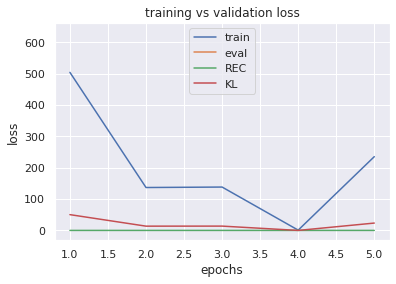

In [7]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from argparse import ArgumentParser
import seaborn as sns;sns.set()

parser = ArgumentParser(description='BetaVAE Model')
parser.add_argument('--batch_size', type=int, default=16)
parser.add_argument('--learning_rate', type=float, default=1e-3)
parser.add_argument('--num_epochs', type=int, default=5)
parser.add_argument('--validation_split', type=float, default=0.2)
parser.add_argument('--beta', type=float, default=10.0)
parser.add_argument('--weight_decay', type=float, default=1e-5)
parser.add_argument('--z_features', type=int, default=64)
parser.add_argument('--mode', type=str, default='train')
parser.add_argument('--device', type=str, default='cuda')

args, unknown = parser.parse_known_args()

DEVICE = args.device
if not torch.cuda.is_available():
    DEVICE = 'cpu'

train_dataset = MNIST('./data', transform=transforms.ToTensor(), train=True, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

split = int(np.floor(args.validation_split * len(train_dataset)))
indices = list(range(len(train_dataset)))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

dataloaders = []
mnist_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,
                                                 sampler=train_sampler)
mnist_val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,
                                               sampler=valid_sampler)

dataloaders.append(mnist_train_loader)
dataloaders.append(mnist_val_loader)

test_dataset = MNIST('./data', transform=transforms.ToTensor(), train=False, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, input):
        return input.view(input.size(0), -1)


class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()

        encoder_pretrained = torchvision.models.densenet121(pretrained=True)

        ##to avoid too small size problem
        for x in encoder_pretrained.modules():
            if isinstance(x, nn.AvgPool2d):
                x.ceil_mode = True

        features_pretrained = next(iter(encoder_pretrained.children()))
        # print(features_pretrained)
        conv0 = features_pretrained.conv0
        weights_conv0 = conv0.weight.data

        conv0_new = torch.nn.Conv2d(
            in_channels=1,
            out_channels=conv0.out_channels,
            kernel_size=conv0.kernel_size,
            stride=conv0.stride,
            padding=conv0.padding,
            bias=False
        )
        conv0_new.weight.data[:] = torch.unsqueeze(weights_conv0[:, 1, :, :], dim=1)

        self.encoder = torch.nn.Sequential()
        z_num_features = 0
        for name, module in features_pretrained.named_children():
            if name == 'conv0':
                module = conv0_new
            elif name == 'norm5':
                z_num_features = module.num_features
            self.encoder.add_module(name, module)
            self.encoder.add_module('avg_pool', torch.nn.AdaptiveAvgPool2d(output_size=1))
            # print(self.encoder) 16*1024

        self.encoder.add_module('reshape', Flatten())

        self.fcmu = nn.Linear(in_features=z_num_features, out_features=16)
        self.fcvar = nn.Linear(in_features=z_num_features, out_features=16)
        self.fcd = nn.Linear(in_features=16, out_features=16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=4, stride=3),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=4, stride=2),
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        #print('x ', x.shape)
        return self.fcmu(x), self.fcvar(x)

    def decode(self, z):
        z = self.decoder(z)
        return torch.sigmoid(z)

    def reparametrize(self, mu, var):
        std = torch.exp(0.5 * var)
        eps = torch.rand_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparametrize(mu, var)
        z = self.fcd(z)
        z = z.view(-1, 16, 1, 1)
        return self.decode(z), mu, var


model = Model()
model = model.to(DEVICE)

if args.mode == 'train':

    optimizer = torch.optim.Adam(params=model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
    print('training started')
    minimum_loss = float('Inf')

    training_losses = []
    rec_losses = []
    KL_losses = []
    validation_losses = []
    epochs = []

    for epoch in range(1, args.num_epochs + 1):
        epochs.append(epoch)

        for dataloader_idx, dataloader in enumerate(dataloaders):
            stage = ''

            if dataloader_idx == 1:
                model = model.eval()
            else:
                model = model.train()

            epoch_loss = []
            epoch_rec_loss = []
            epoch_KL_loss = []

            for batch in dataloader:
                batch_img, batch_y = batch
                batch_img = batch_img.to(DEVICE)
                #print('btach_img_shape 1', batch_img.shape)
                batch_img = batch_img.view(batch_img.size(0), 1, 28, 28)
                #print('btach_img_shape 2', batch_img.shape)
                y, mu, var = model.forward(batch_img)

                recons_loss = F.mse_loss(y, batch_img)
                KLD = -0.5 * torch.sum(1 + torch.log(var.pow(2)) - mu.pow(2) - var.pow(2))
                loss = recons_loss + args.beta * KLD

                epoch_loss.append(loss.to('cpu').item())
                epoch_rec_loss.append(recons_loss.to('cpu').item())
                epoch_KL_loss.append(KLD.to('cpu').item())

                if dataloader_idx == 0:
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

            if dataloader_idx == 0:
                training_losses.append(np.mean(epoch_loss))
                rec_losses.append(np.mean(epoch_rec_loss))
                KL_losses.append(np.mean(epoch_KL_loss))
                stage = 'train'
            else:
                validation_losses.append(np.mean(epoch_loss))
                stage = 'eval'

            if dataloader_idx == 0:
                print(
                    f'epoch: {epoch} stage: {stage} loss: {np.mean(epoch_loss)} rec: {np.mean(epoch_rec_loss)} KL: {np.mean(epoch_KL_loss)}')
            else:
                print(f'epoch: {epoch} stage: {stage} loss: {np.mean(epoch_loss)}')

            if dataloader_idx == 1:
                if minimum_loss > np.mean(validation_losses):
                    minimum_loss = np.mean(validation_losses)
                    torch.save(model.to('cpu'), 'vae_best.pt')
                    model = model.to('cuda')
                    print('Model is saving :) :)')

    plt.plot(epochs, training_losses, label="train")
    plt.plot(epochs, validation_losses, label="eval")
    plt.plot(epochs, rec_losses, label="REC")
    plt.plot(epochs, KL_losses, label="KL")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('training vs validation loss')
    plt.legend()
    plt.show()

if args.mode == 'eval':
    model = torch.load('vae_best.pt')
    model.eval()


    def splot(img1, img2):
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(transforms.ToPILImage()(img1))
        axarr[1].imshow(transforms.ToPILImage()(img2))
        plt.show()


    with torch.no_grad():
        test_image1 = next(iter(test_dataloader))[0][14]

        test_image = test_image1.view(1, 1, 28, 28)
        model_img, mu, var = model.forward(test_image)
        model_img = model_img.squeeze(0)

        splot(test_image1, model_img)








